# Introduction
* Hello, our names are Cristian, and Geary
* This is a project detailing the process undertaken to predict the cases of `Language` (Code)

### Project Objectives
- Document code, process, findings, and key takeaways.
- Make your process repeateable and your report (notebook) easy to read and follow.
- Ask exploratory questions of your data. Answer questions through charts and statistical tests.
- Construct a model to predict customer churn using classification techniques.
- Refine your work into a Report.
- Be prepared to answer panel questions.

### Business Goals
- Predict a language based on the contents of the Readme
- Construct a ML classification model that accurately predicts language.
- Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

### Executive Summary
* Relied on unique common words and counts for bulk of feature differientation to predict `Language`
* Feature sets informed by the combination of Feature Engineering and Word Counts
* Model gain on predictive performance vs. baseline prediction was improvement on test set (from ~20% -> ~40%)

In [9]:
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import unicodedata
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

import env
from wrangle import * 
from explore_modeling import *

# Acquire Phase

> if looking to refresh data source (GITHUB REPOSITORIES) change to true
 - Goes to the most forked pages and finds links to the repositories
 - Uses the url and passes to the api to pull down the info using API key and User-Name
    - (will need your own env file with both)
 - Creates dataframe from url, language primarily written in (code), and the README
> Otherwise, pulls from csv that has info cached

In [10]:
refresh_datasource=False
# pretty much as the variables describe
# if true, goes and gets updated repo names (from most forked)
# uses api key and user name to acquire the data from the repo list
if refresh_datasource:
    list_repo = get_repo_names()
    df= to_update_or_not_to_udpate(True,list_repo)
else:
    #pulls from csv
    df= to_update_or_not_to_udpate(False)

# Prepare phase
> starting the prepare on the dataframe
 - drops na if applicable (on language and readme contents)
 - cleans using regex and language type (encode and decode)
 - tokenizes
 - removes stop words
 - stems
 - lems
> feature creation/clean/tidy
 - sorts articles by language and finds "set" of words for each
 - compares sets and returns only unique for each language
 - compares each article to unique common word and returns count as feature

In [11]:
#send the df into a function to clean, prep and tidy (see markdown above for process)
lang, df, most_common_list, count_feature_list, low_lang_count = prep_work(df)
df.shape, df.info()

dropped na
cleaned
stemmed
lemmed
<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 529
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   repo                          487 non-null    object
 1   language                      487 non-null    object
 2   readme_contents               487 non-null    object
 3   clean                         487 non-null    object
 4   stemmed                       487 non-null    object
 5   lemmatized                    487 non-null    object
 6   clean_lang                    487 non-null    object
 7   count_set_lem                 487 non-null    int64 
 8   count_most_common_JavaScript  487 non-null    object
 9   count_most_common_Python      487 non-null    object
 10  count_most_common_Java        487 non-null    object
 11  count_most_common_HTML        487 non-null    object
 12  count_most_common_Other       487 non-null  

((487, 14), None)

<function matplotlib.pyplot.show(close=None, block=None)>

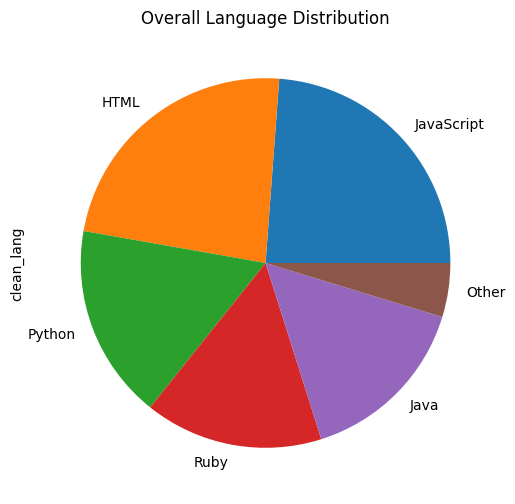

In [12]:
## makes a plot of the distributions of the langauges
plt.figure(figsize= (12,6))
df["clean_lang"].value_counts(normalize=True).plot.pie(title=("Overall Language Distribution"),fontsize=10)
plt.show

# End of Prepare and Acquire:
- Cleaned and tidied our Readmes through tokenization and lemmetization
- Counted a match on unique wordcount for each language for most common
- Sorted Languages and returned word counts
- Distributions of primary languages are relatively similar


# <hr style="border-bottom: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

Let's investigate if our Languages contain inequal distributions of unique words (to itself) enough "oomph" to be considered significant
##  **Hypothesis 1 - Are the mean count_values of Unique Words in Each Language equal to the Population in relation to Non-Repeating Words for the ReadMes**

> $H_0$: The mean values of `Non-Repeating Words(Readme)_langauge` will not be signifcantly different from `Non-Repeating Words(Readme)_population`.    
> $H_a$: Rejection of Null ~~The mean values of `Non-Repeating Words(Readme)_langauge` will not be signifcantly different from `Non-Repeating Words(Readme)_population`.~~  
> alpha = .05  
> - Conclusion: There is enough evidence to reject our null hypothesis for SOME cases

count_set_lem <-target | clean_lang <-population name | JavaScript <-sample name
We fail to reject the null hypothesis ( JavaScript as a sample has equal mean values to clean_lang as a population regarding Non-Repeating Words ) t=-0.18046, p=0.85711
----------
count_set_lem <-target | clean_lang <-population name | Python <-sample name
We reject the null Hypothesis ( P̶y̶t̶h̶o̶n̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶e̶a̶n̶_̶l̶a̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶N̶o̶n̶-̶R̶e̶p̶e̶a̶t̶i̶n̶g̶ ̶W̶o̶r̶d̶s̶ ) t=2.65409, p=0.00955
----------
count_set_lem <-target | clean_lang <-population name | Java <-sample name
We fail to reject the null hypothesis ( Java as a sample has equal mean values to clean_lang as a population regarding Non-Repeating Words ) t=0.75473, p=0.45281
----------
count_set_lem <-target | clean_lang <-population name | HTML <-sample name
We reject the null Hypothesis ( H̶T̶M̶L̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶

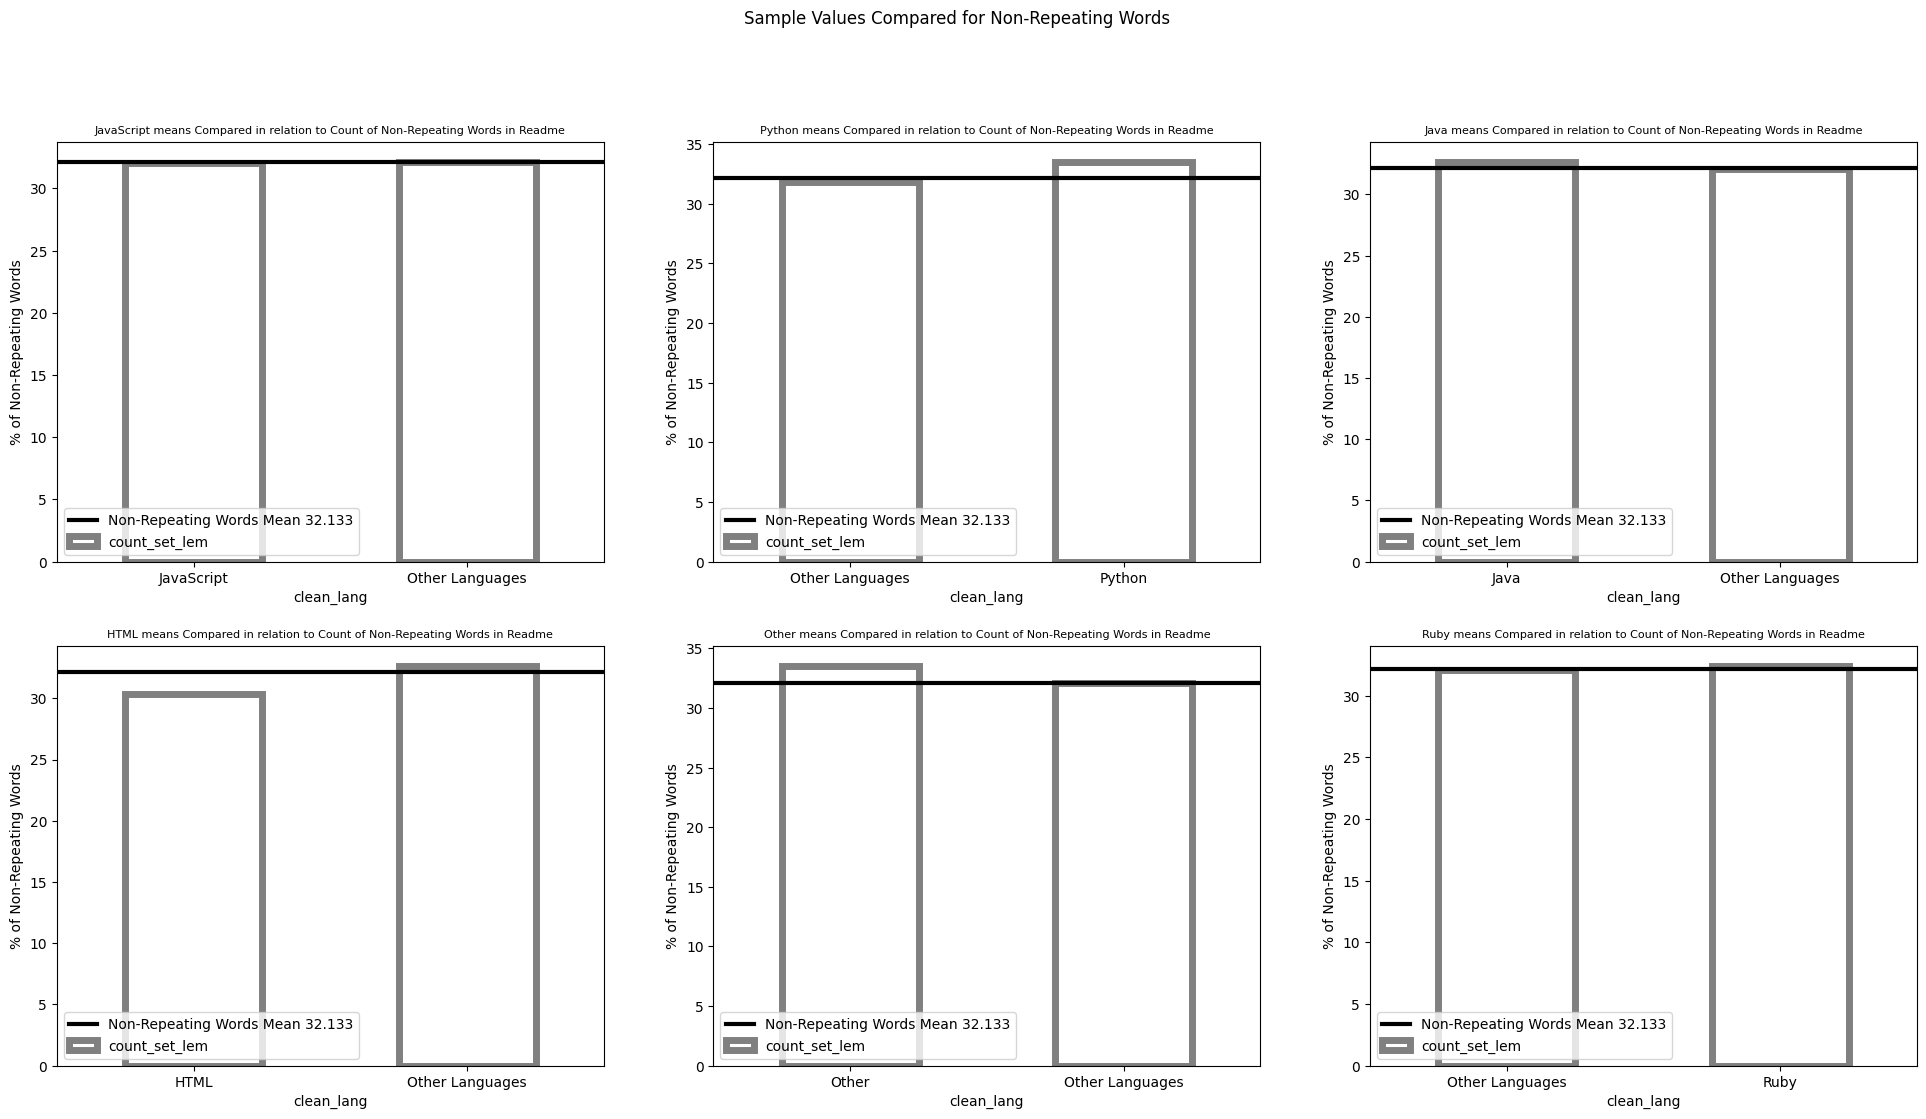

The ones that are similar in value -> ('JavaScript', 'Java', 'Other', 'Ruby') 
The ones not similar in value -> ('Python', 'HTML')


In [13]:
## sends in df to a tailored function
## compares each unique language and thier distributions of counts for unique common words to the population
## returns charts for ease of understanding results
explore_ttest_lang_setcount(df)

### Takeaways:
- The languages of Python, Other, and HTML share similar values in their word count set "uniqueness"
    - This is not a good feature to use to determine Language for these values
- The languages of Java, TypeScript, and JavaScript are unique in their word count set "uniqueness"
    - This is a good feature to use to determine Language for these values  
    
*`This feature is not the answer by itself and will need addtional features to help determine Language, however it is not completly worthless and we will be considering it's use in modeling.`*

# <hr style="border-bottom: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## Hypothesis 2
>Does each language have unique bigrams?


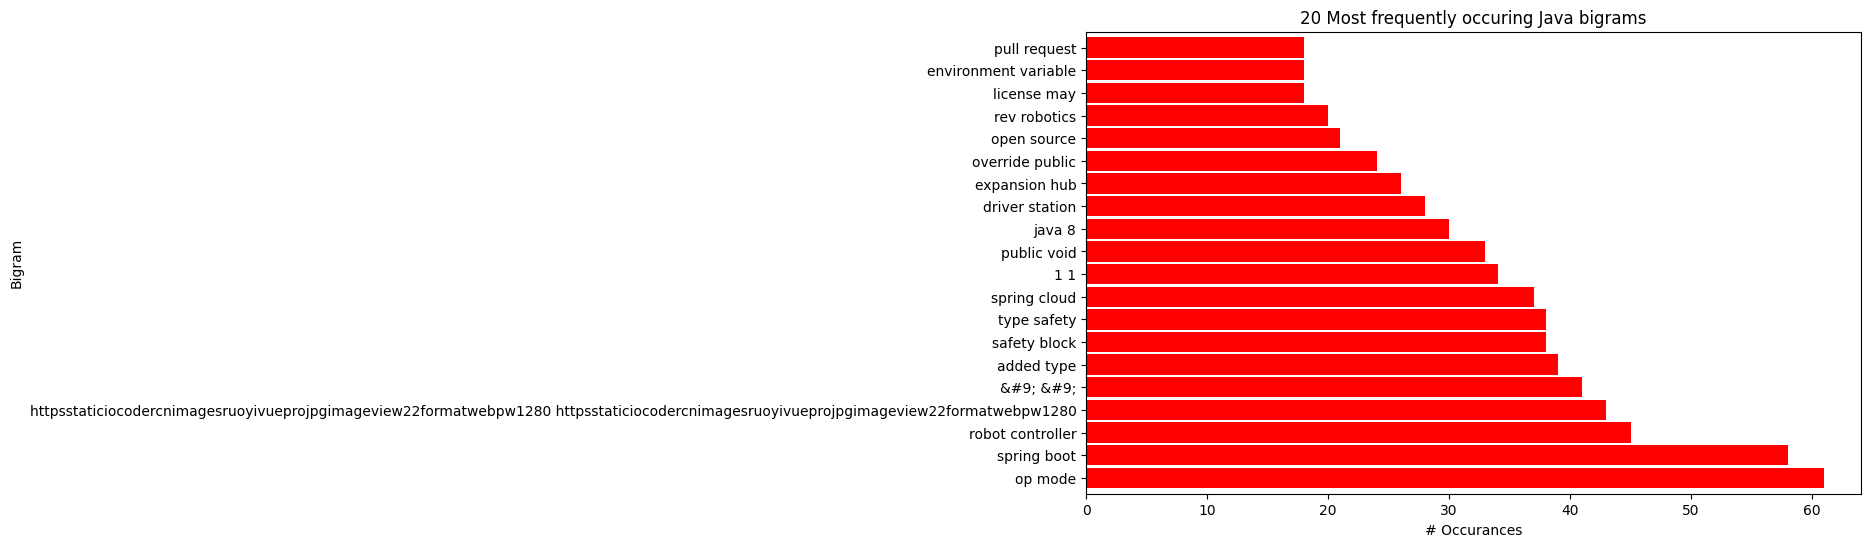

In [14]:
lang_bigrams(df,language="Java")

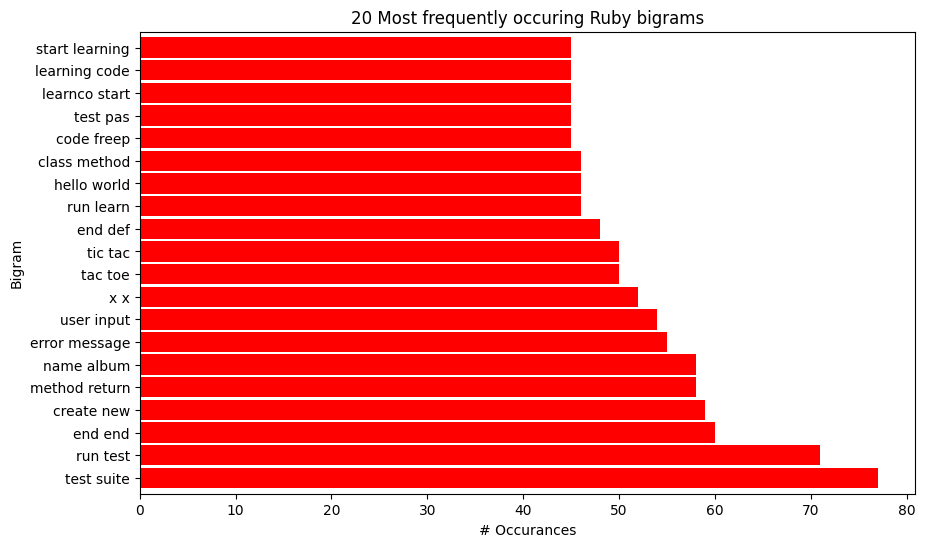

In [15]:
lang_bigrams(df,language="Ruby")

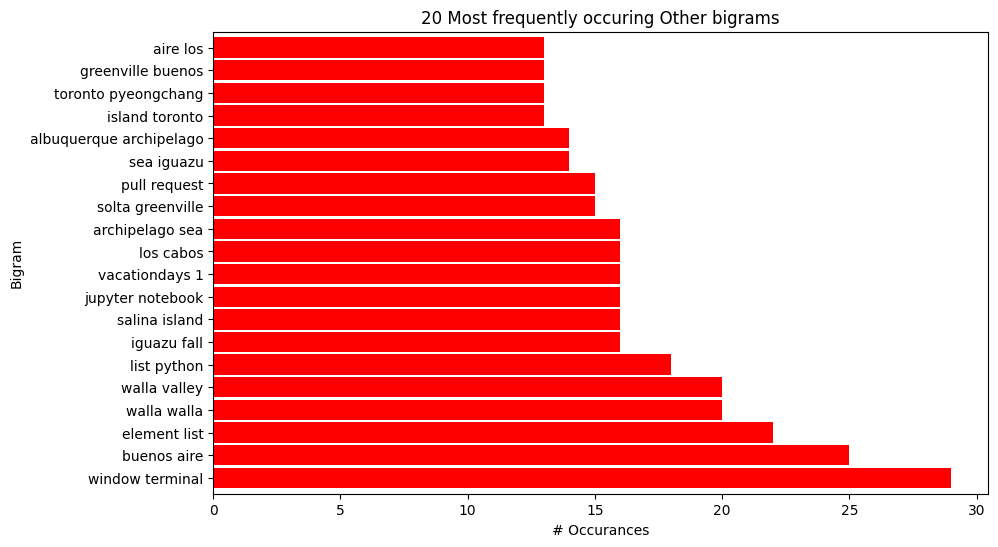

In [16]:
lang_bigrams(df,language="Other")

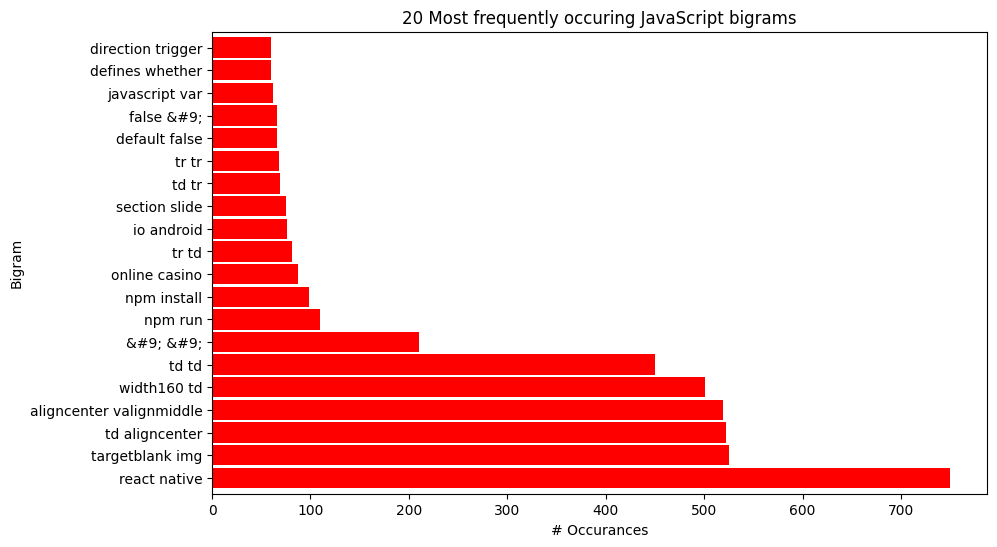

In [17]:
lang_bigrams(df,language="JavaScript")

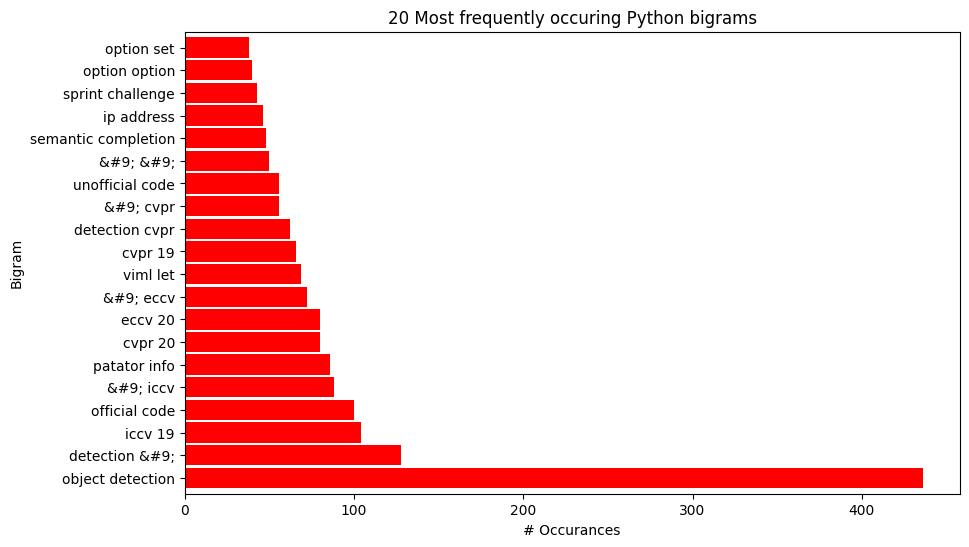

In [18]:
lang_bigrams(df,language="Python")

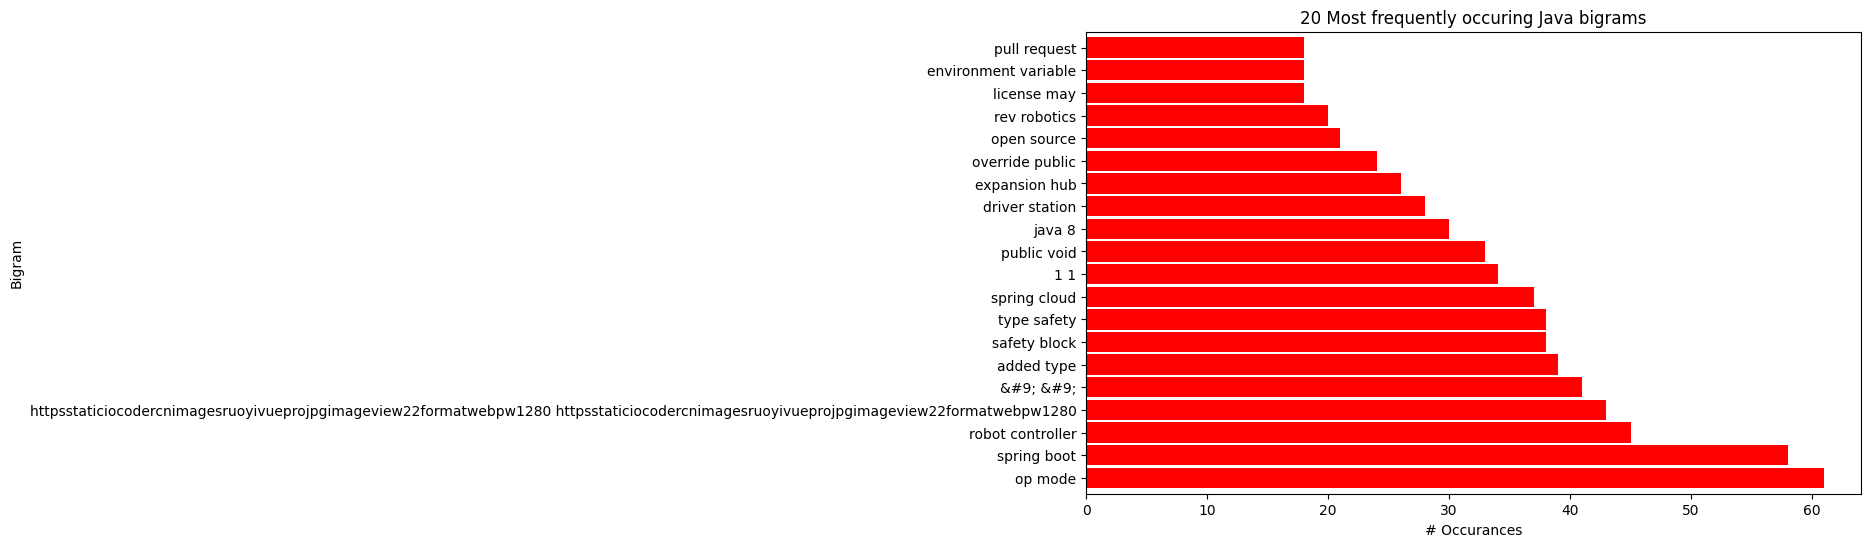

In [19]:
lang_bigrams(df)

### Takeaway: 
- We can see here that for the most part, each language does have it's own unique set of bigrams, however there is also instances of presumably unique words scoring high due to repetive use in their respective readmes. This indicates that there is some concern in using bigrams as an feature in modeling

# <hr style="border-bottom: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

##  **Hypothesis 3 - Is the distribution of Readmes similar for each Language**
 
> - Conclusion: Yeah they're pretty similar with a catch-all of Other being the lowest

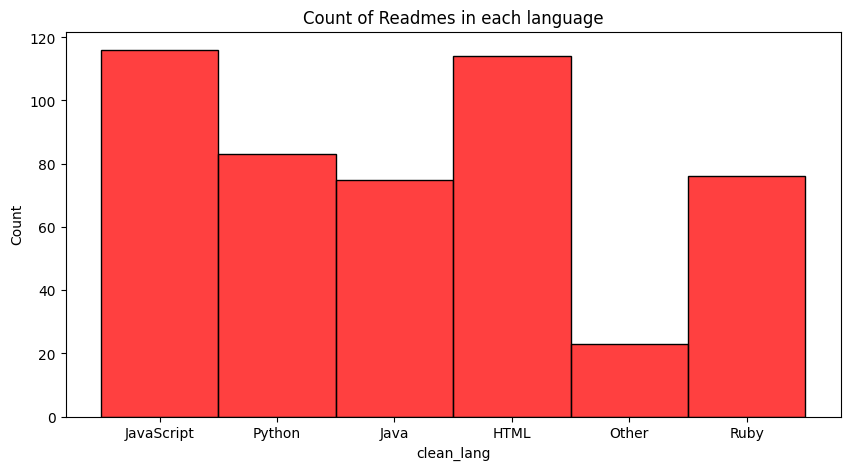

In [31]:
## creates a hist plot of each languages count
plt.figure(figsize=(10,5))
sns.histplot(df.clean_lang, color= 'red')
plt.title("Count of Readmes in each language")
plt.show()

### Takeaways:
 - There is enough data here for us to be selective and be able to model appropriately

# <hr style="border-bottom: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

##  **Hypothesis 4 - Is the distribution of Count of Common words unique to a language a cood indicator of that language (Porportionality)**

> $H_0$: The distribution of `Non-Repeating Words(Readme)_langauge` will be consistent between languages.    
> $H_a$: Rejection of Null ~~The distribution of `Non-Repeating Words(Readme)_langauge` will be consistent between languages..~~  
> alpha = .05  
> - Conclusion: There is enough evidence to reject our null hypothesis for ALL cases

---
chi^2 = 33810.1376, p = 0.00000, degf = 25
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  L̶a̶n̶g̶u̶a̶g̶e̶s̶ ̶i̶s̶ ̶n̶o̶t̶ ̶d̶i̶f̶f̶e̶r̶e̶n̶t̶ ̶i̶n̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶ ̶o̶f̶ ̶C̶o̶m̶m̶o̶n̶ ̶U̶n̶i̶q̶u̶e̶ ̶C̶o̶u̶n̶t̶ )


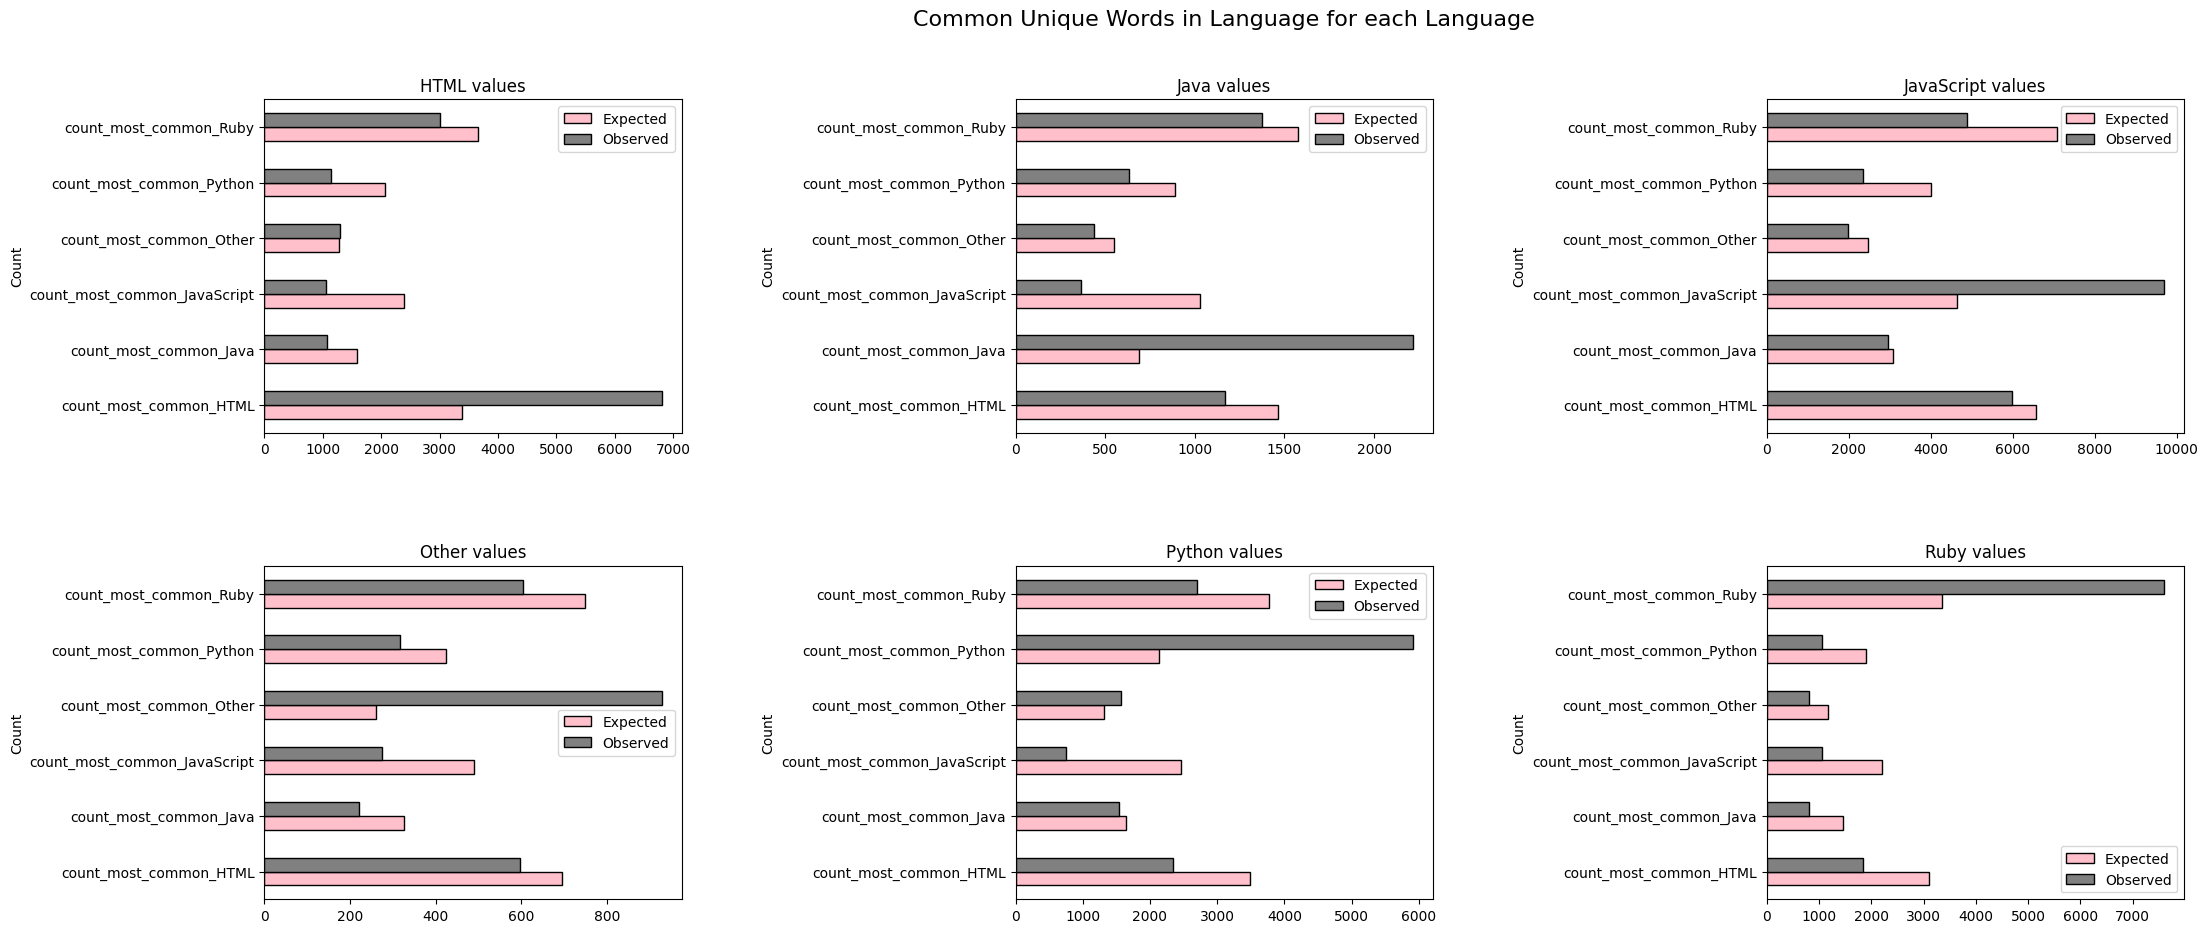

In [20]:
## sends in df to a tailored function
## does chi2 test for all features (hence high degf)
## returns pval
## produces comparison charts of observed and expected for ease of understanding results
chi2_for_lang(df)

### Takeaways:
- Using Count Unique Words for each language holds different porportions from what would be a normal distribution, and as such is a good indicator for use in modeling to predict our class.
- In all cases the percentage difference between expected and observed is pretty good and indicates it will be applicable across a large portion of the dataset
  
  *`This will be a helpful indicator for modeling and will be recommended for it's use`*

## Explore Takeaways:
>Count of common words for each language will be a strong indicator for classifying Language

# Modeling
## remember to pull in other fresh dataframes

In [21]:
# sends in df to a tailored function which returns validate and test 
#        (goes and acquires if update is true, otherwise pulls from csv)
#  splits new acquired data, 
#  scales all
X_train,X_validate,X_test,y_train,y_validate,y_test,train_scaled,validate_scaled,test_scaled = prep_for_modeling(df,lang,update=False)

dropped na
cleaned
stemmed
lemmed
(21, 14) (22, 14)


Using RFE to reduce the amount of features (due to using large amout of word count)

In [22]:
#makes a copy of the y_train, and goes through each variable to encode the results to pass to rfe
# for rfe recommendations, if stastical backing for results will utlize top results to produce
# a more generalizable model (feature reduction)
y_train_encoded = y_train.copy()
for num,stri in enumerate(y_train_encoded.unique()):
    #print(num,stri)
    y_train_encoded.replace({stri:num},inplace=True)
rec_list = rfe(X_train,y_train_encoded,10)
best_list = rec_list[rec_list["Rank"]>5]["Var"].tolist()

                              rfe_ranking
object                                  1
function                                1
ruby                                    1
method                                  1
create                                  1
type                                    1
javascript                              1
count_most_common_JavaScript            1
user                                    1
return                                  1


we see here a recommendation of blend of features using both the most common unique and word counts for specific words, this makes sense and we will utilize this moving into modeling

## Baseline Values

In [23]:
round(df.clean_lang.value_counts(normalize=True).nlargest(1)*100,1).apply(str)+"%"

JavaScript    23.8%
Name: clean_lang, dtype: object

### Baseline is 23%

### Train/Validate Modeling
> goes through multiple models  
- Decision Tree  
     - Loops through and determines best leaf amount for accuracy `leafs`  
- Logistic Regresssion  
     - Static C (playing with it did not change results dramatically)  
- Random Forest  
     - Loops through and determines best leaf and depth  
- KNearestNeighbors  
     - Uses N for amount of Languages  
> Passes in train with `best_list` recommendations for fit  
> Predicts on validate with same recommendations  
> Produces a classification report for each  

In [24]:
# sends in dataframes and series of results for prediction comparision, see above for process
leafs = init_modeling(X_train[best_list],X_validate[best_list],y_train,y_validate)

              precision    recall  f1-score   support

        HTML       0.79      0.60      0.68       114
        Java       0.41      0.80      0.54        75
  JavaScript       0.74      0.66      0.70       116
       Other       1.00      0.09      0.16        23
      Python       0.86      0.77      0.82        83
        Ruby       0.67      0.64      0.66        76

    accuracy                           0.66       487
   macro avg       0.75      0.59      0.59       487
weighted avg       0.72      0.66      0.66       487
 	 Decision Tree classification report on train set
              precision    recall  f1-score   support

        HTML       0.20      0.33      0.25         3
        Java       0.43      1.00      0.60         3
  JavaScript       0.50      0.25      0.33         4
       Other       0.00      0.00      0.00         2
      Python       0.67      0.50      0.57         4
        Ruby       0.75      0.60      0.67         5

    accuracy              

# Takeaways:
- Best accuracy found with Decision Tree (48%), will be using that for moving forward to testing
- Knearest, RandFor, and LogReg where not as accuracte and but be increased with better fine tuning

In [25]:
clf = DecisionTreeClassifier(max_depth= int(leafs), random_state= 1, criterion="gini")
clf = clf.fit(X_train[best_list],y_train)
y_pred_test_dt = clf.predict(X_test[best_list])

print(leafs,"leafs")
print(classification_report(y_test, y_pred_test_dt), "\t Decision Tree classification report on test set")

6 leafs
              precision    recall  f1-score   support

        HTML       0.29      0.50      0.36         4
        Java       0.25      1.00      0.40         2
  JavaScript       1.00      0.40      0.57         5
       Other       0.00      0.00      0.00         1
      Python       0.33      0.20      0.25         5
        Ruby       1.00      0.40      0.57         5

    accuracy                           0.41        22
   macro avg       0.48      0.42      0.36        22
weighted avg       0.60      0.41      0.42        22
 	 Decision Tree classification report on test set


### Test model Takeaway
Improves on baseline accuracy by 21%. Would recommend this model over baseline!

# Conclusion

## Summary of Key Findings
* A large portion of ReadMe content was unusual words and mispellings
* Common Unique Word Count creation was able to show difference in `Language` prediction
* Feature sets informed by wordcounts performed best on model through validation phase
    * Best model utilized combination of word count per language and overall counts per word
* Model gain on predictive performance vs. baseline prediction was decent on test set
    * Baseline accuracy: ~20%
    * Test model accuracy: ~40% (Higher is better)  
    
## Suggestions and Next Steps
* Dive deeper into what makes each language's ReadMe unique
* Take a look at adding more features into the model to create a more robust predictor
    - Boolean values on significance (common unique word count passes threshould)
* Investigate features highlighted by RFE and see how they perform
* Possible look at reducing variation within features by analyzing significance
    - Identify features were `Language` variation was driven by primarly outliers (looking at you HTML)
* May consider creating different or tailored specific models
* Take different approach to combining the data
    - Rely more on the raw features rather than feature engineering